<h1 style="color: cyan;">Sea Animals Classifier</h1>

<h3 style="color: cyan">The initial code was adapted from Kaggle dataset/code by vencerlanz09.</h3>
Credits to him! <br>
This is the link to his dataset: https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste <br>
This is the link to his Notebook in Kaggle: https://www.kaggle.com/code/vencerlanz09/sea-animals-classification-using-efficeintnetb7 <br>


<h3 style='color:yellow'>Import Required Libraries</h3>

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model, layers

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
sns.set_style('darkgrid')

<h3 style='color:yellow'>Create Helper Functions</h3>

In [2]:
import requests

url = 'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'
response = requests.get(url)

# Save Content to a File
with open('helper_functions.py', 'wb') as file:
    file.write(response.content)

print("File downloaded successfully!")

# Check File
import os
print(os.listdir())

# Import Functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot, make_confusion_matrix

File downloaded successfully!
['helper_functions.py', 'input', 'load_data.ipynb', 'requirements.txt', 'sea_animals_classifier.ipynb', '__pycache__']


<h3 style='color:yellow'>Load Sea Animals Dataset</h3>

In [3]:
BATCH_SIZE = 32 # adjust 
TARGET_SIZE = (224, 224)

# Walk through each directory
dataset = "./input/sea-animals-image-dataset"
walk_through_dir(dataset)

There are 23 directories and 0 images in './input/sea-animals-image-dataset'.
There are 0 directories and 497 images in './input/sea-animals-image-dataset\Clams'.
There are 0 directories and 500 images in './input/sea-animals-image-dataset\Corals'.
There are 0 directories and 499 images in './input/sea-animals-image-dataset\Crabs'.
There are 0 directories and 782 images in './input/sea-animals-image-dataset\Dolphin'.
There are 0 directories and 497 images in './input/sea-animals-image-dataset\Eel'.
There are 0 directories and 494 images in './input/sea-animals-image-dataset\Fish'.
There are 0 directories and 845 images in './input/sea-animals-image-dataset\Jelly Fish'.
There are 0 directories and 499 images in './input/sea-animals-image-dataset\Lobster'.
There are 0 directories and 500 images in './input/sea-animals-image-dataset\Nudibranchs'.
There are 0 directories and 562 images in './input/sea-animals-image-dataset\Octopus'.
There are 0 directories and 500 images in './input/sea-an

<h3 style='color:yellow'>Place Data into a Dataframe</h3>

In [4]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [5]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("./input/sea-animals-image-dataset").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

C:\Users\Nina\AppData\Local\Temp\ipykernel_21772\3576681314.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')


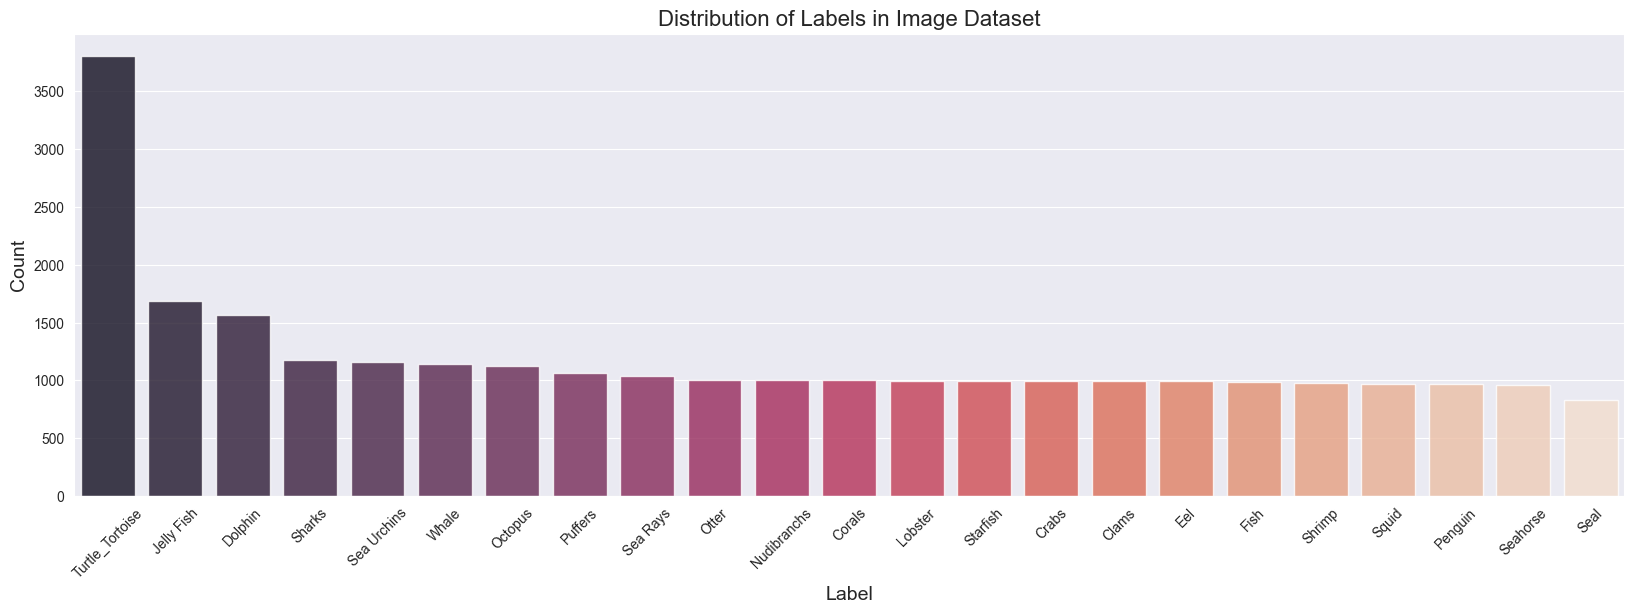

In [6]:
label_counts = image_df['Label'].value_counts()

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45) 
plt.show()

<h3 style='color:yellow'>Visualize Images from the Dataset</h3>

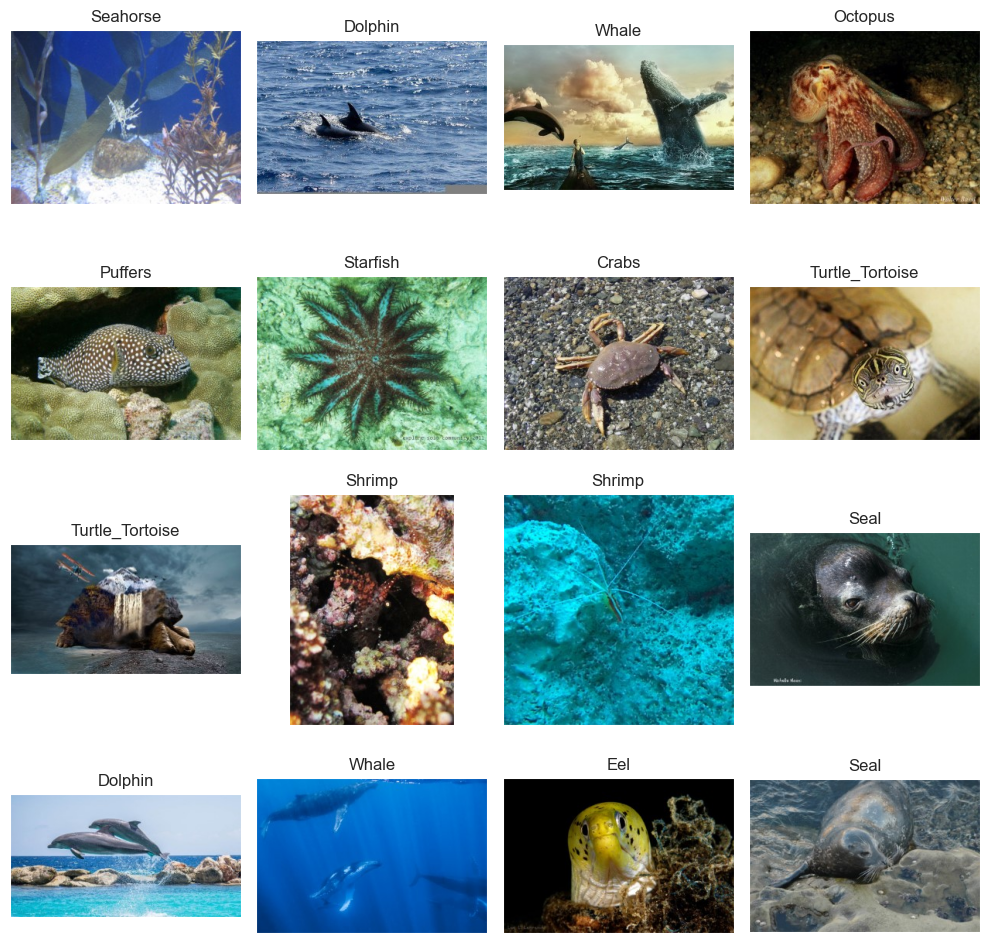

In [7]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

<h3 style='color:yellow'>Compute Error Rate: Analysis</h3>

In [8]:
def compute_ela_cv(path, quality):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    # Compress image to JPEG in memory
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    result, encimg = cv2.imencode('.jpg', img, encode_param)
    if not result:
        raise Exception("Image encoding failed.")
    comp = cv2.imdecode(encimg, cv2.IMREAD_COLOR)
    # Convert images to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    comp = cv2.cvtColor(comp, cv2.COLOR_BGR2RGB)
    # Compute absolute difference
    diff = cv2.absdiff(img, comp)
    # Compute grayscale by averaging color channels
    diff_gray = diff.astype(np.float32).mean(axis=2)
    # Normalize to 0-255
    min_val, max_val = diff_gray.min(), diff_gray.max()
    if max_val > min_val:
        diff_gray = (diff_gray - min_val) * (255.0 / (max_val - min_val))
    else:
        diff_gray = np.zeros_like(diff_gray)
    return diff_gray.astype(np.uint8)

# Randomly select a file from the given folder
def random_sample(folder):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    return os.path.join(folder, random.choice(files))

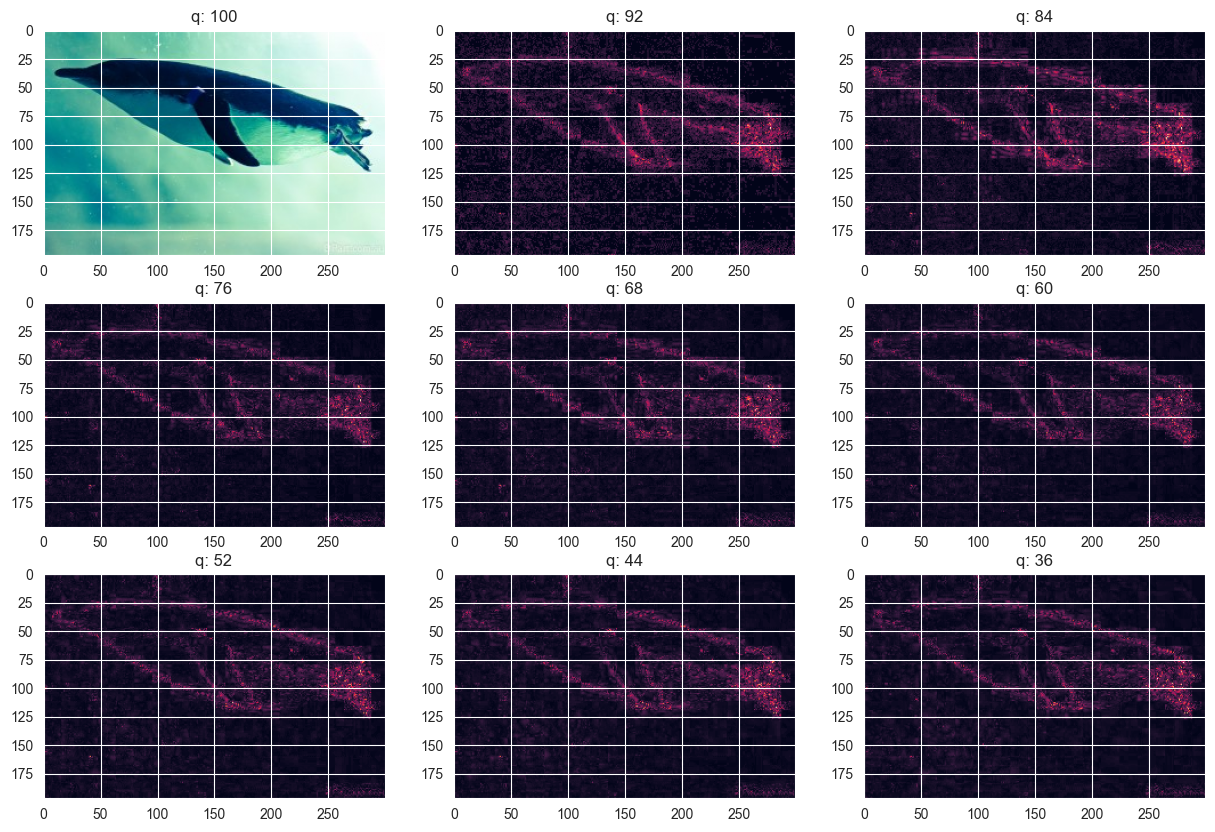

In [9]:
# View random sample from the dataset
p = random_sample('./input/sea-animals-image-dataset/Penguin')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

<h3 style='color:yellow'>Preprocess Data</h3>

In [10]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [11]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 17550 validated image filenames belonging to 23 classes.
Found 4387 validated image filenames belonging to 23 classes.
Found 5485 validated image filenames belonging to 23 classes.


In [12]:
class_labels = list(test_images.class_indices.keys())
print(class_labels)

['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']


In [13]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.Resizing(224, 224),
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
])

<h3 style='color:yellow'>Train Model: Part 1</h3>

In [14]:
# Load the pre-trained EfficientNetB0 model
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),  
    include_top=False,  # Exclude the fully connected layers
    weights='imagenet',  # Load pre-trained ImageNet weights
    pooling='max'  # Use global average pooling
)

# Freeze the pre-trained layers
pretrained_model.trainable = False


In [15]:
# Create checkpoint callback
checkpoint_path = "animals_classification_model_checkpoint.weights.h5"  # Add .weights.h5 extension
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [16]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

<h3 style='color:yellow'>Train Model: Part 2</h3>

In [17]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)

outputs = Dense(23, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001), # adjust if needed
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Unfreeze the last few layers
for layer in pretrained_model.layers[-4:]:
    layer.trainable = True

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # adjust if needed

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100, # adjust if needed
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "animal_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/animal_classification/20250501-210856


c:\Users\Nina\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 263s 464ms/step - accuracy: 0.1720 - loss: 3.8963 - val_accuracy: 0.5728 - val_loss: 1.6318
Epoch 2/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 230s 418ms/step - accuracy: 0.4543 - loss: 1.9206 - val_accuracy: 0.7121 - val_loss: 1.1247
Epoch 3/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 231s 420ms/step - accuracy: 0.5671 - loss: 1.5251 - val_accuracy: 0.7723 - val_loss: 0.8709
Epoch 4/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 234s 427ms/step - accuracy: 0.6440 - loss: 1.2672 - val_accuracy: 0.7992 - val_loss: 0.7615
Epoch 5/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 235s 428ms/step - accuracy: 0.6810 - loss: 1.1122 - val_accuracy: 0.8245 - val_loss: 0.6749
Epoch 6/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 235s 428ms/step - accuracy: 0.7140 - loss: 0.9958 - val_accuracy: 0.8313 - val_loss: 0.6209
Epoch 7/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 235s 429ms/step - accuracy: 0.7422 - loss: 0.9116 - val_accuracy: 0.8425 - val_loss: 0.5891
Epoch 8/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 234s 426ms/step - accuracy: 

<h3 style='color:yellow'>Evaluate Model</h3>

In [18]:
model.save('animals_classification_model_checkpoint.keras')
loss, accuracy = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(loss))
print("Test Accuracy: {:.2f}%".format(accuracy * 100))


    Test Loss: 0.30254
Test Accuracy: 93.75%


<h3 style='color:yellow'>Visualize Loss Curves</h3>

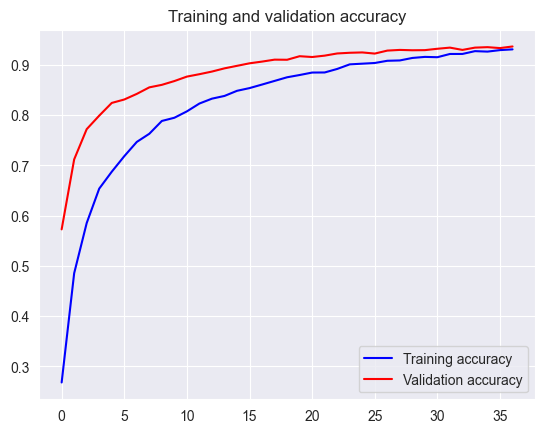

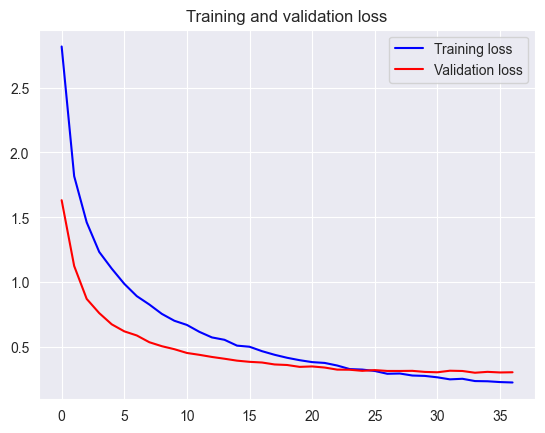

In [19]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

<h3 style='color:yellow'>Make Predictions on the Test Data</h3>

In [20]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

172/172 ━━━━━━━━━━━━━━━━━━━━ 59s 336ms/step
The first 5 predictions: ['Sea Rays', 'Turtle_Tortoise', 'Octopus', 'Corals', 'Turtle_Tortoise']


<h3 style='color:yellow'>Plot the Classification Reports and Confusion Matrix</h3>

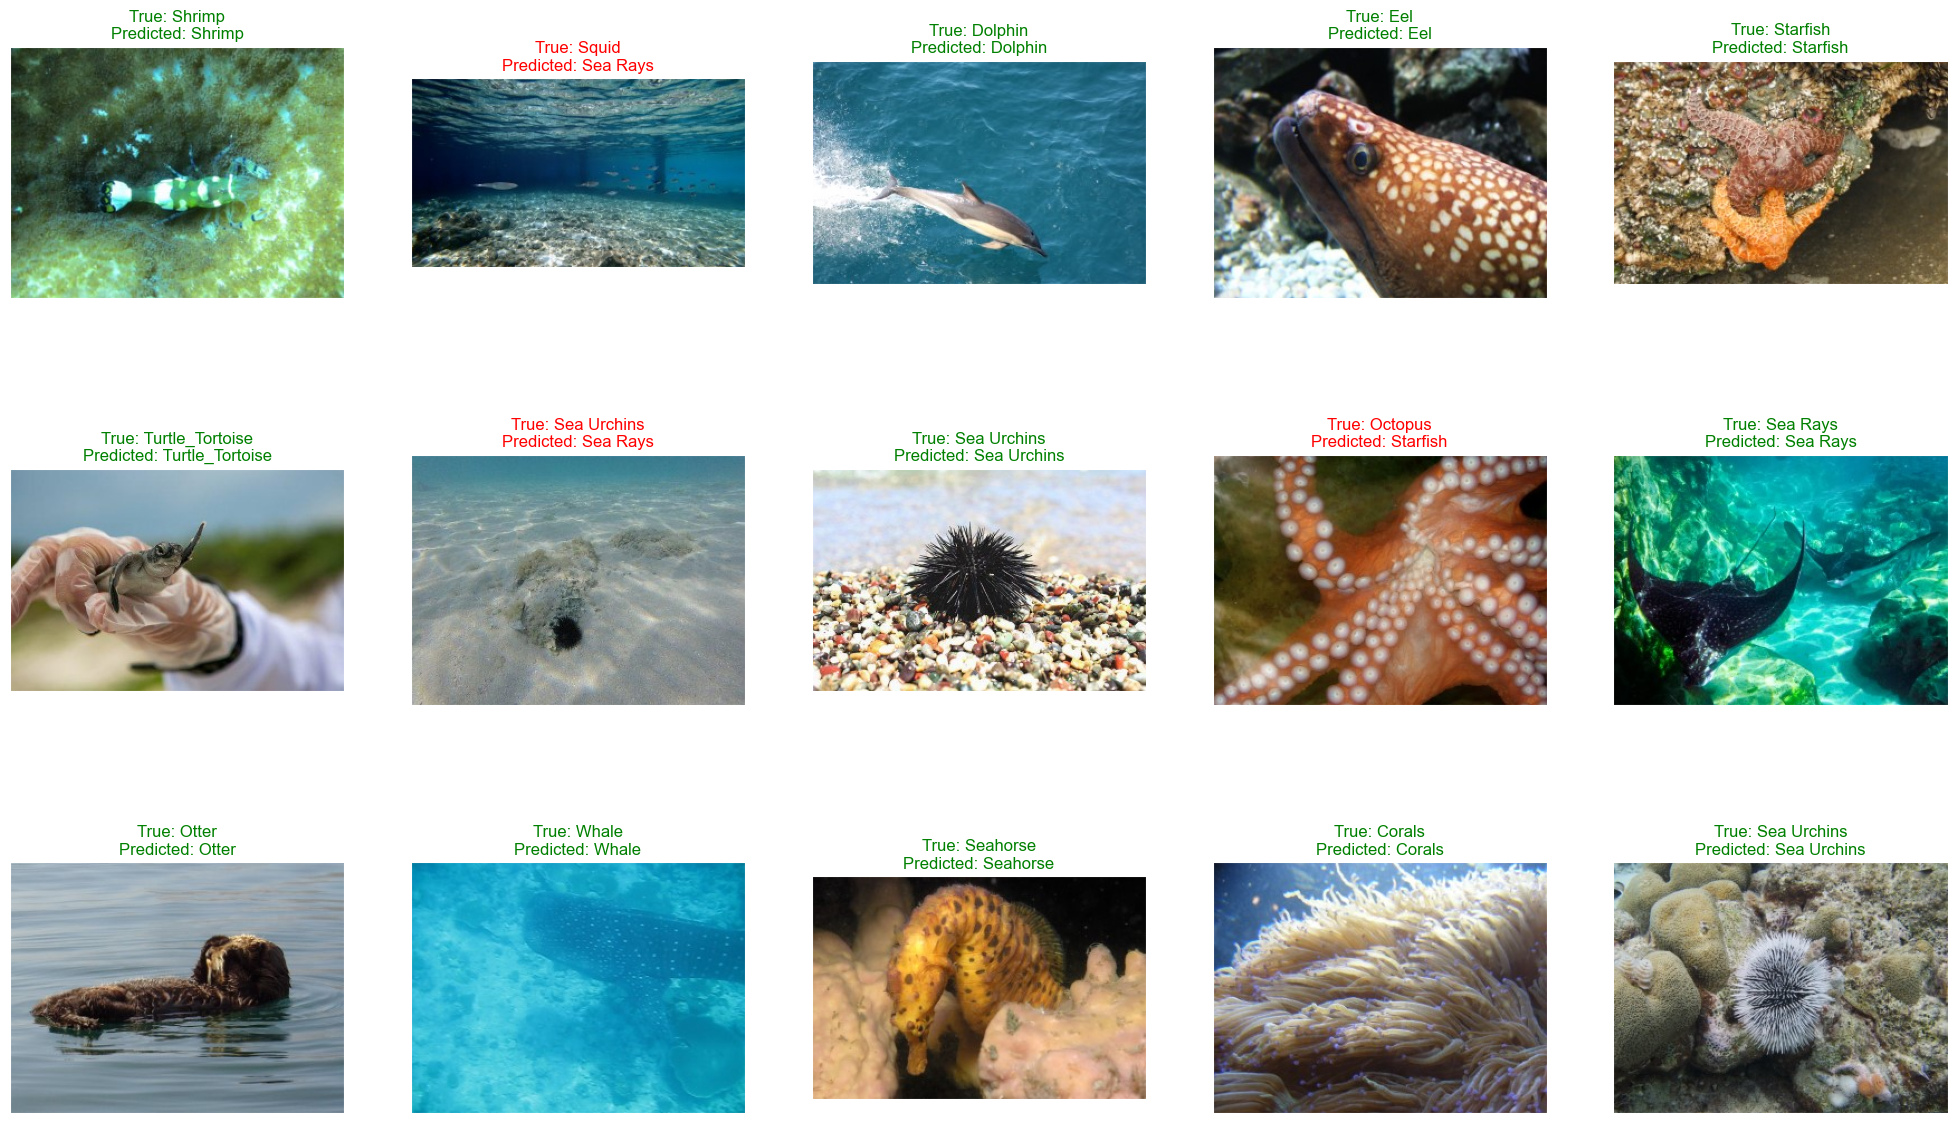

<Figure size 640x480 with 0 Axes>

In [21]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [22]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

          Clams       0.87      0.88      0.87       186
         Corals       0.86      0.86      0.86       192
          Crabs       0.99      1.00      0.99       194
        Dolphin       0.96      0.94      0.95       315
            Eel       0.87      0.91      0.89       204
           Fish       0.89      0.85      0.87       198
     Jelly Fish       0.98      0.98      0.98       328
        Lobster       0.93      0.93      0.93       194
    Nudibranchs       0.93      0.92      0.92       189
        Octopus       0.88      0.84      0.86       223
          Otter       0.99      1.00      0.99       189
        Penguin       0.98      0.95      0.97       180
        Puffers       0.88      0.92      0.90       207
       Sea Rays       0.92      0.94      0.93       209
    Sea Urchins       1.00      0.98      0.99       270
       Seahorse       0.96      0.95      0.95       196
           Seal       0.99    

In [23]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
Clams             0.871658  0.876344  0.873995   186.000000
Corals            0.863874  0.859375  0.861619   192.000000
Crabs             0.989796  1.000000  0.994872   194.000000
Dolphin           0.960912  0.936508  0.948553   315.000000
Eel               0.869159  0.911765  0.889952   204.000000
Fish              0.893617  0.848485  0.870466   198.000000
Jelly Fish        0.975758  0.981707  0.978723   328.000000
Lobster           0.928205  0.932990  0.930591   194.000000
Nudibranchs       0.925134  0.915344  0.920213   189.000000
Octopus           0.882075  0.838565  0.859770   223.000000
Otter             0.989529  1.000000  0.994737   189.000000
Penguin           0.982759  0.950000  0.966102   180.000000
Puffers           0.880184  0.922705  0.900943   207.000000
Sea Rays          0.920188  0.937799  0.928910   209.000000
Sea Urchins       1.000000  0.981481  0.990654   270.000000
Seahorse          0.958763  0.948980  0.953846   196.000000
Seal              0.987421  0.923529  0.954407   170.000000
Sharks            0.904167  0.904167  0.904167   240.000000
Shrimp            0.851485  0.891192  0.870886   193.000000
Squid             0.969388  0.883721  0.924574   215.000000
Starfish          0.957944  1.000000  0.978520   205.000000
Turtle_Tortoise   0.982256  0.989783  0.986005   783.000000
Whale             0.866071  0.946341  0.904429   205.000000
accuracy          0.937466  0.937466  0.937466     0.937466
macro avg         0.930884  0.929599  0.929867  5485.000000
weighted avg      0.938125  0.937466  0.937472  5485.000000

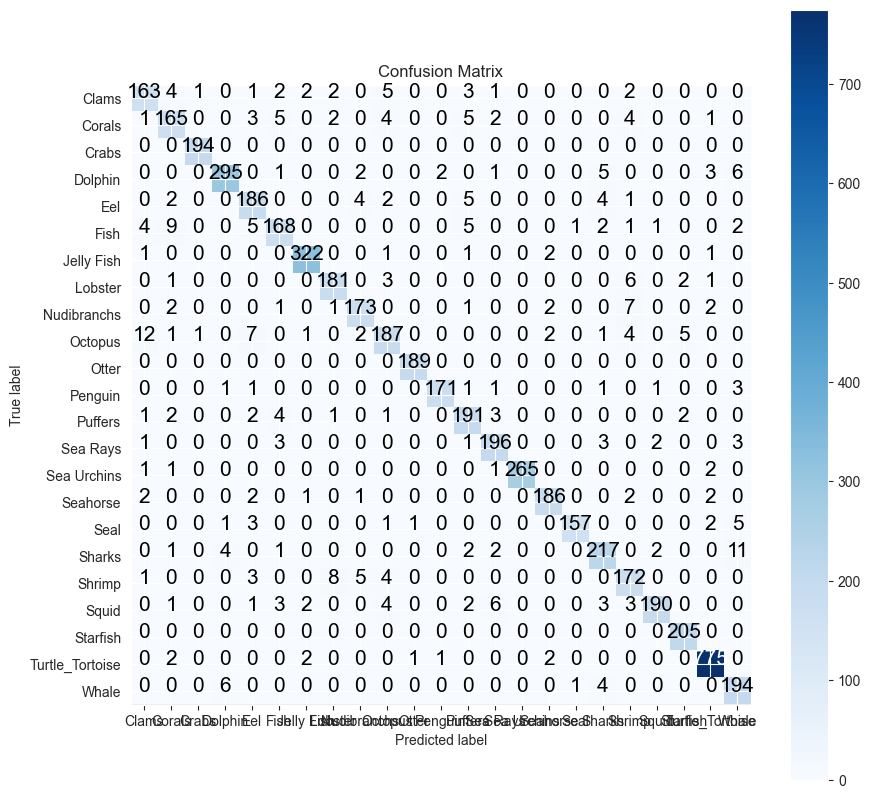

In [24]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [25]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

C:\Users\Nina\AppData\Local\Temp\ipykernel_21772\2384243434.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


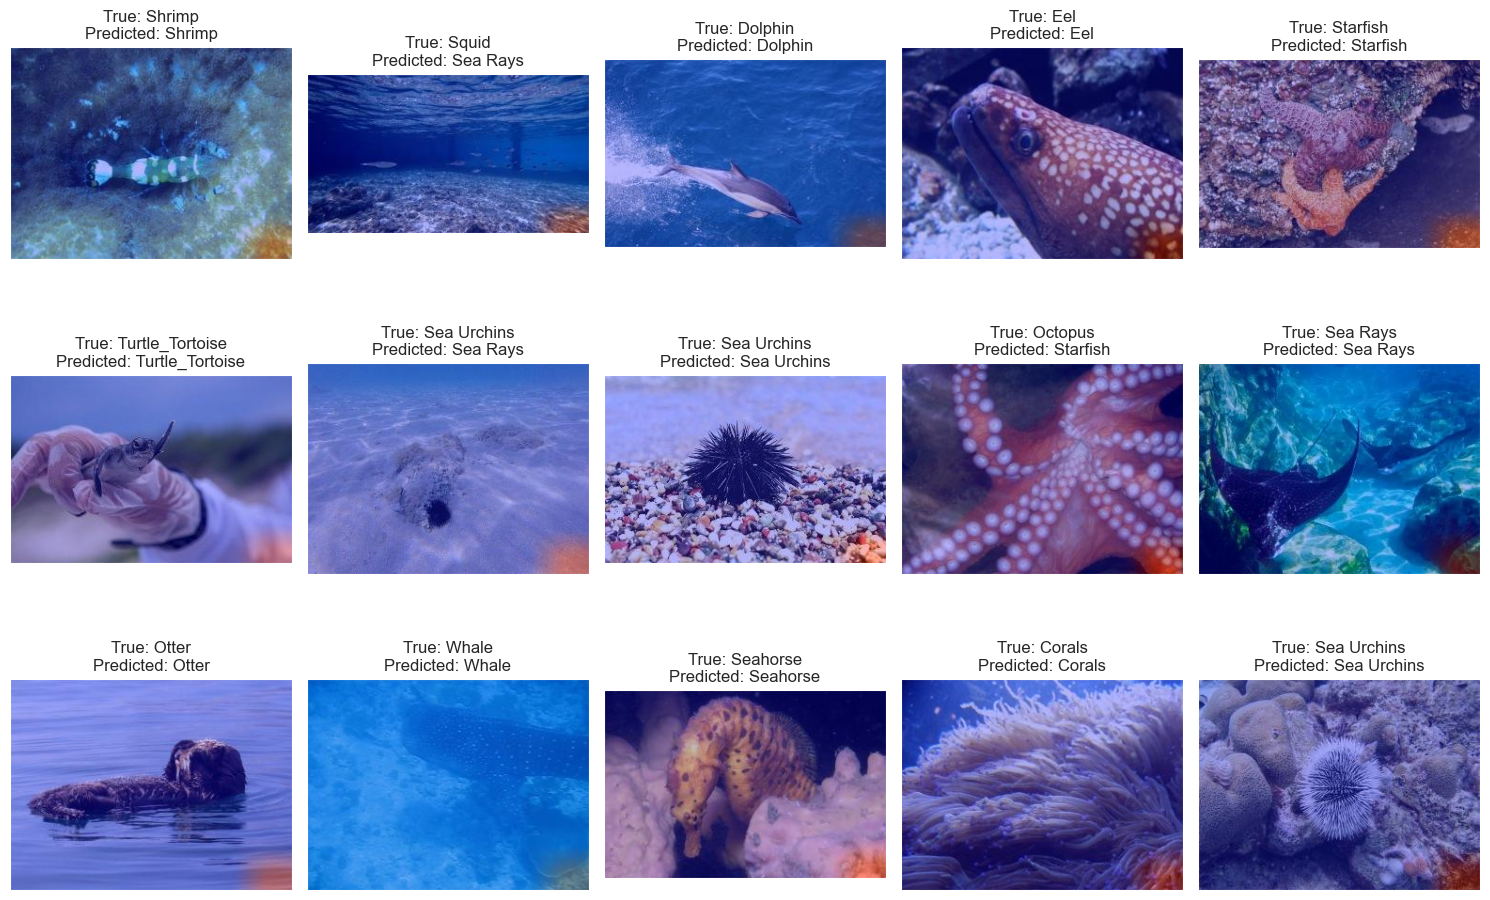

In [27]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()